<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 4


## Important notes

**Submission deadline:**
**lab session of the week 7.11-11.11 2022**

**Points: 1+2+2+1=4**

Please let us know about any problems with it -- we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## MNIST

In [13]:
# Standard IPython notebook imports
import warnings
from sklearn import datasets
import seaborn as sns
import scipy.stats as sstats
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import httpimport
import os
%matplotlib inline


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments',
                            module='common', branch='nn18'):
    from common.plotting import plot_mat

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')


In [14]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [15]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
X_trn = mnist_full_train_data_uint8[:50000]
y_trn = mnist_full_train_labels_int64[:50000]
X_tst = mnist_full_train_data_uint8[50000:]
y_tst = mnist_full_train_labels_int64[50000:]

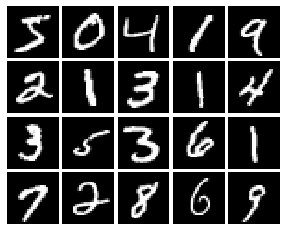

In [16]:
plot_mat(X_trn[:20, None], cmap='gray')

In [17]:
X_trn = X_trn.reshape(-1,28*28)
X_tst = X_tst.reshape(-1,28*28)

## kNN cosine similarity 

In previous problems you've discovered how to compute nearest neighbors using Euclidian distance. However, Euclidian distance is not the only one that you can use to measure proximity of points.

In Machine Learning very often we calculate similarity between vectors using the dot product or the correlation coefficient between them, which we can also call the cosine similarity. You will see this in Deep Learning class in Convolutional Neural Networks for Image Recognition tasks, and in Transformers for Natural Language Processing.

Let $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors. Their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.



To get an idea why it can work let us plot the correlation matrix for an ordered (according to the 0,1,...,9 labels) subset of the MNIST data.

In [18]:
X_subset = X_trn[:2000]
y_subset = y_trn[:2000]


In [19]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

<AxesSubplot:>

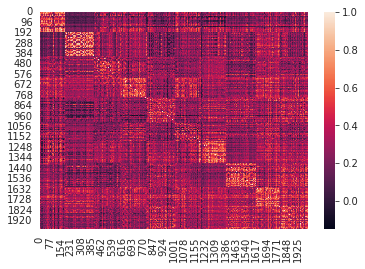

In [20]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

You can see that squares at the diagonal are brighter. It's because these squares correspond to the vectors with the same labels.

### Normalization [1p]

For the cosine similarity to work, we need data that will be normalized. Meaning, that we want every row (and row corresponds to an image) to have zero mean and standard deviation equal to `1`.
Roughly it should mean that instead of operating on the initial $x$ representing an image we prefer to operate on $$ (x - \mbox{mean}(x))/\mbox{std}(x).$$

Task: take `X_trn` and normalize it, let the output be in `X_norm_trn`.

In [21]:
X_norm_trn = (X_trn - np.mean(X_trn, axis=1)[:, np.newaxis]) / np.std(X_trn, axis=1)[:, np.newaxis]
X_norm_tst = (X_tst - np.mean(X_tst, axis=1)
         [:, np.newaxis]) / np.std(X_tst, axis=1)[:, np.newaxis]


In [22]:
np.mean(X_norm_trn, axis=1).round(12)

array([ 0.,  0.,  0., ..., -0., -0., -0.])

In [23]:
np.std(X_norm_trn, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

If everything went ok, then you should get a correlation matrix of `X_trn`, simply by multiplying `X_norm_trn` by itself (but transposed ofc). Also, we need to divide it by 784; you know why?

<AxesSubplot:>

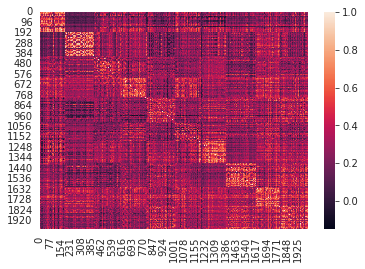

In [24]:
sns.heatmap(X_norm_trn[np.argsort(y_subset)] @ X_norm_trn[np.argsort(y_subset)].T/784)

### Implement kNN with cosine similarity [2p]

Implement k-nearest neighbor algorithm, but this time using cosine similarity. 
This time implement it fully on your own. On top of that make it look like a model satisfying the standard sklearn API:

Of course, during hyperparameter tuning of parameter `k` you may not want to calculate the correlation matrix all over again. Feel free to change the above API into:

In [25]:
class kNearestNeighborsCosine:
    def __init__(self, k):
        self.dists = None
        self.y_trn = None
        self.targets = None
        self.k = k

    def fit(self, X_trn, y_trn, X_tst, dists=None):
        self.y_trn = y_trn
        if dists is not None:
            self.dists = dists
        else:
            nom = X_trn.dot(X_tst.T)
            diagA = (X_trn ** 2).sum(1)
            diagB = (X_trn ** 2).sum(1)
            denom = np.sqrt(diagA[:, np.newaxis]).dot(np.sqrt(diagB[np.newaxis, :]))
            self.dists = (nom / denom) * -1
        
        closest = np.argsort(self.dists, axis=0)
        self.targets = self.y_trn[closest]
    
    def predict(self, X_tst, loo=False):
        predictions = sstats.mode(self.targets[:self.k+1])[
            0] if not loo else sstats.mode(self.targets[1:self.k+1])[0]
        predictions = predictions.ravel()
        return predictions


where `dists` is the matrix containing the cosine similarity. In the sklearn implementation similar behavior is obtained via parameter `metric="precomputed"`, see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

### Implement kNN with leave-one-out [2p]

Perform the same leave-one-out error validation, and `k` tuning as in Lab Assignment 3.

In [26]:
preds, errs = {}, {}
ks = [1, 3, 5, 7, 9]
nom = X_norm_trn.dot(X_norm_tst.T)
diagA = (X_norm_trn ** 2).sum(1)
diagB = (X_norm_tst ** 2).sum(1)
denom = np.sqrt(diagA[:, np.newaxis]).dot(
    np.sqrt(diagB[np.newaxis, :]))
dists = (nom / denom) * -1



In [27]:
closest = np.argsort(dists, axis=0)

In [28]:
for k in ks:
  knn = kNearestNeighborsCosine(k)
  knn.targets = y_trn[closest]
  preds[k] = knn.predict(X_norm_tst, loo=True)
  errs[k] = (preds[k] != y_tst).mean()

errors = [{'K': k, 'err_rate': (errs[k])} for k in ks]
results_df = pd.DataFrame(errors) 
plt.figure()
sns.regplot(x='K', y='err_rate', data=results_df, x_estimator=np.mean, order=3)

# Don't know what's happening, spent like 4 hours trying to solve it but kernel is crashing when trying to plot

: 

: 

### Implement batched kNN for MNIST [1p]

Implement the same batched approach to classify all the images from the test set.